As shown in Random_Forest_Segmentation notebook, Decision trees can be used as a segmentation tool, where each leaf represents a segment.<br>
But what if we want to divide our population into larger segments than model's leaves?<br>
Here, provided a very simple example , where Kc region in Seattle is divded into sub-regions. Each sub-region contains a few zipcodes:<br>

1. Build a decision tree classifier: features are X and Y coordinates. labels are the zipcodes. Then, trim/prune the tree by defining lower maximal leaves number.
2. ***Surplrisingly, as the tree becomes more pruned. Entropy criterion provides more evenly balanced leaves size than Gini index ***
3. Finally, provided a function to extract from the decision tree the decision path for each sample.

Such a method can also be useful when we would like to convert clusters which were generated by unsupervised methods into simple decision rules (i.e. generate classifcation tree where label is the clusters, the extract their paths)
<h4>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_housing = pd.read_csv('kc_house_data.csv')

#### A very brief EDA

In [3]:
df_housing.shape

(21613, 21)

In [4]:
df_housing.isnull().sum().sum()

0

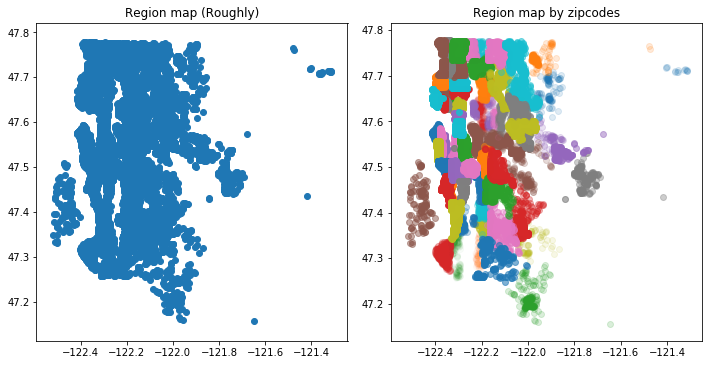

In [5]:
# Show region map Vs region with zipcodes map
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_housing.long , df_housing.lat)
for i,(z,df) in enumerate(df_housing.groupby('zipcode')):
    ax[1].scatter(df.long , df.lat,alpha=i/len(df_housing.zipcode.unique()))
    plt.tight_layout()
    
ax[0].set_title('Region map (Roughly)')
ax[1].set_title('Region map by zipcodes')
plt.show()

In [6]:
print('Total number of zipcodes : ' , len(df_housing['zipcode'].unique()) )

Total number of zipcodes :  70


## 1. Build a classification tree for initial segments generation:

In [7]:
from sklearn import tree

In [8]:
cols_X = ['long','lat']

In [9]:
def model_n_plot(num_leafs,criterion,plot = True,ax=None):
    tree_c = tree.DecisionTreeClassifier(max_leaf_nodes=num_leafs,criterion=criterion)
    tree_c.fit(X = df_housing[cols_X] , y=df_housing['zipcode'])
    
    if plot:
        plt.figure(figsize=(5,4))
        pred_zipcodes = tree_c.predict(X = df_housing[cols_X] )
        if ax: 
            for i,(z,df) in enumerate(df_housing.groupby(pred_zipcodes)):
                ax.scatter(df.long , df.lat,alpha=i/len(df_housing.zipcode.unique()))
            ax.set_title(criterion+'_'+str(num_leafs)+'_num_leaves')
        else:
            for i,(z,df) in enumerate(df_housing.groupby(pred_zipcodes)):
                plt.scatter(df.long , df.lat,alpha=i/len(df_housing.zipcode.unique()))
            plt.show()
        
        print ('Model accuracy with '+criterion+ ' criterion' , tree_c.score(df_housing[cols_X] , df_housing['zipcode']))
    
    return (pd.Series(tree_c.apply(df_housing[cols_X])).value_counts() / len(df_housing)).std()

Model accuracy with gini criterion 0.9160227640771758
Model accuracy with entropy criterion 0.9150048581872021


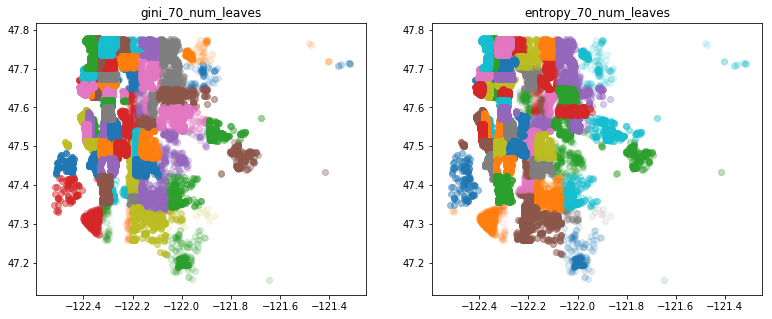

In [10]:
fig,ax = plt.subplots(1,2,figsize = (13,5))
mdl1 = model_n_plot(num_leafs=70,criterion='gini',plot=True,ax=ax[0])
mdl2 = model_n_plot(num_leafs=70,criterion='entropy',plot=True,ax=ax[1])


#### A short glimpse on the left side of the maps (lat ~-122.5 , long~47.4) may suggest that entropy criterion splits the zipcodes more evenly (In case it must assign it a wrong class) than gini index. <br>To prove this point , let's compare the evenness (std) of leaves size as we further prune the tree (i.e. allow less leaves):

In [11]:
std_leaves_entpoy = {}
std_leaves_gini = {}
for i in range(70,10,-10):
    std_leaves_entpoy[i]= model_n_plot(num_leafs=i,criterion='entropy',plot=False)
    std_leaves_gini[i]  = model_n_plot(num_leafs=i,criterion='gini',plot=False)

In [12]:
df_stds = pd.DataFrame([std_leaves_entpoy,std_leaves_gini],index=['entropy_std','gini_std']).T

## 2. Entropy criterion provides more balanced segments than gini criterion:

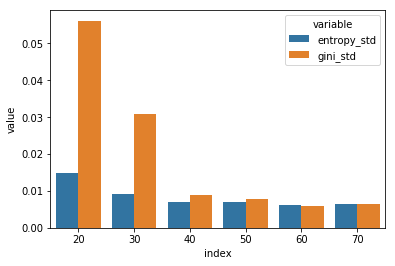

In [13]:
sns.barplot(data=pd.melt(df_stds.reset_index(),id_vars='index') ,
            x = 'index',y='value',hue = 'variable')

### Lower number of max leaves -> more errounous classifications ->  leaves size are more balanced for entropy criterion.<br> i.e. as the model gets more under-fitted, entropy criterion will result a model with more balanced leaves.

#### Visualization of the pruned tree (max leaves =30) proves this point

Model accuracy with gini criterion 0.561328829870911
Model accuracy with entropy criterion 0.5742839957433027


0.009227972657349016

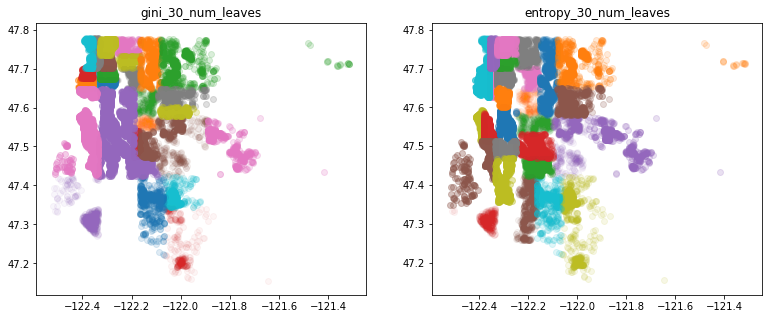

In [14]:
fig,ax = plt.subplots(1,2,figsize = (13,5))
model_n_plot(num_leafs=30,criterion='gini',plot=True,ax=ax[0])
model_n_plot(num_leafs=30,criterion='entropy',plot=True,ax=ax[1])

#### We can clearly see the more even distribution of segments accross the map of entropy criterion.

## 3. Provide explicit path for selected samples:

In [15]:
# Apply model. Use hyperparameters as decided above 
tree_c = tree.DecisionTreeClassifier(max_leaf_nodes=30,criterion='entropy')
tree_c.fit(X = df_housing[cols_X] , y=df_housing['zipcode'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
# This function takes the estimator and it's characteristics (i.e. leaves nodes , corresponding features names , etc. )
# Then , iterates over all splits and extracts path of the selected  sample
def get_rules_of_tree(node_index,leave_id , sample_id,X_samples , feature , feature_name,threshold):
    my_s = []
    for node_id in node_index: # Iterate for each split point in the path
        if leave_id[sample_id] == node_id:  # If reached leaf , don't add rule (nothing to add)
            None
            
        else: # < -- Else, add decision rule
            if (X_samples.iloc[sample_id, feature[node_id]] <= threshold[node_id]): # select decision sign 
                threshold_sign = "<="
            else:
                threshold_sign = ">"
            # Then unify in a string :  feature name , sign and threshold 
            my_s += [str(feature_name[feature[node_id]])+threshold_sign+str(round(threshold[node_id],2))+'&']
    #Finally, return all samples paths in a data frame
    return pd.DataFrame(index = [X_samples.index[sample_id]], data = [my_s])


In [17]:
X_samples = df_housing[cols_X].sample(5) # select samples to inspect (Here, 5 at random)
feature_name = pd.Series(cols_X) # Set features name as a dictionary by their index
estimator = tree_c # Set the estimator

feature = estimator.tree_.feature
threshold = estimator.tree_.threshold
node_indicator = estimator.decision_path(X_samples)
leave_id = estimator.apply(X_samples)

df_paths = pd.DataFrame()

for sample_id in range(len(X_samples)): # for each sample (iterate by index)
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]] #Take nodes (split points) for the sample 
    
    # Call the function to return parsed path
    df = get_rules_of_tree(node_index,leave_id , sample_id,X_samples , feature , feature_name,threshold)
    df_paths = df_paths.append(df)

#Show paths for each sample
display(df_paths.astype(str).sum(1).str.replace('nan',''))

3285     long<=-122.25&lat<=47.6&long<=-122.33&lat>47.5...
21127    long<=-122.25&lat<=47.6&long>-122.33&lat>47.47...
4754     long<=-122.25&lat>47.6&long<=-122.33&long>-122...
13361    long<=-122.25&lat>47.6&long>-122.33&lat>47.7&l...
11134    long>-122.25&lat<=47.58&lat<=47.42&long<=-122....
dtype: object

In [18]:
# Finally , example for a path of first sample in the batch
df_paths.iloc[0].dropna()

0    long<=-122.25&
1        lat<=47.6&
2    long<=-122.33&
3        lat>47.51&
4     long>-122.38&
Name: 3285, dtype: object